# Tutrial on interacting with ReaktoroBlock
Demonstration of how use reaktoro block in practical settings. 

## Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling
* cyipopt - Solver necessary for use with gray box models
* Reaktoro-pse -python package for building rektoro block
* WaterTAP - Unit models

## Demonstration structure 
* Background on speciation and reaktoro-pse philosophy 
* Setting up basic speciation block and calculating properties for a feed composition
    * Demonstrate key configuration options
    * Key display options
* Adding reaktoro block to a RO water tap model for calculation of local osmotic pressure, scaling tendency, and pH


## Reaktoro-PSE API and structure 
Reaktoro-pse is a wrapper for enabling use of reaktoro (https://reaktoro.org/) as a graybox model in IDAES compatible modeling platforms such as WaterTAP. This is not a replacement for reaktoro or higher level API for reaktoro. 

The general objective to it provide a structure for user to to provide:

    (1) Method for specifying inputs for reaktoro 
    (2) Configure rekatoro to use desired databases and activity models 
    (3) Simplify building configurations for equilibrium calculations using apparent and exact speciation
    (4) Specify outputs supported by reaktoro and custom outputs built using rektoro database information and outputs 

The general API structure is shown in Figure bellow. The figure shows the type of inputs and outputs and how they are handled by core api to configure reaktoro graybox model. 

<img src="reaktoro_pse_api.png" width="1000" height="650">

Reaktoro-pse supports all available databases and activity models provided by reaktoro:
* Please refer here for information on [databases](https://reaktoro.org/tutorials/basics/loading-databases.html) (all are supported) 
* Please refer here for information on [activity models](https://reaktoro.org/tutorials/basics/specifying-activity-models.html) (all are supported, included chain operations, or passing in pre-configured activity models) 

Reaktoro-pse supports all properties that provide as single floating point or real value as an output from chemical and aqueous properties: 
* [Chemical properties](https://reaktoro.org/api/classReaktoro_1_1ChemicalProps.html)
* [Aqueous properties](https://reaktoro.org/api/classReaktoro_1_1AqueousProps.html)
* Pyomo build properties, which are custom properties built in pyomo that use chemical properties or aqueous properties 

## ReaktoroBlock builds reaktoro graybox usings standard IDAES state block methods

The ReaktoroBlock automates construction of reaktoro graybox, providing range of configuration of options to simplify performing equilibrium chemistry calculations
* Enables construction of speciation block and propagation of exact spetiation to property block to enable chemistry modification
* Supports indexing 
* Provides options to configure reaktoro property block (and if constructed speciation block) 
* Uses core api functionality to automatically scale input and output variables and constraints if user does not provide any
* Automatically scales gray box jacobian 
* Uses many defaults to simplify configuration and usage for typical calculations 

**Minimal configuration options required for RreaktoroBlock:**
* Database and database file selection
* Activity models for phases being considered
* Input apparent or exact species mol or mass flows (**concentrations are not supported!**)
* If speciation block is needed (if exact speciation is not provided then generally yes)
* System states (temperature, pressure, or pH, unless they are being solved for)
* Outputs of interest 

### Example for speciation of seawater and use with RO model

## Import needed modules

In [302]:
## Import core components
# Pyomo core components
from pyomo.environ import (
    Var,
    Constraint,
    TransformationFactory,
    Reals,
    ConcreteModel,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from pyomo.network import Arc

# Ideas core components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor,get_scaling_factor
from idaes.core.util.model_statistics import degrees_of_freedom
from watertap.core.solvers import get_solver
from idaes.core.util.scaling import constraint_scaling_transform
from idaes.core.util.initialization import propagate_state
from idaes.models.unit_models import Feed
from pyomo.util.calc_var_value import calculate_variable_from_constraint

# WaterTAP core components
import watertap.property_models.NaCl_prop_pack as properties

from reaktoro_pse.reaktoro_block import ReaktoroBlock

import reaktoro

### Configure sea water feed composition and constraints

In [303]:

'''Composition of sea water with ion concentration in mg/L'''
sea_water_composition={
    'Na':10556,
    'K':380,
    "Ca":400,
    'Mg':1262,
    'Cl':18980,
    'SO4':2649,
    'HCO3':140,
}
sea_water_ph=7.56


m = ConcreteModel()
# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)
# create seawater property model
m.fs.properties = properties.NaClParameterBlock()
# build feed
m.fs.feed = Feed(property_package=m.fs.properties)

ions=list(sea_water_composition.keys())
m.fs.feed_ion_concentration=Var(ions,initialize=1,bounds=(0,None),units=pyunits.mg/pyunits.L)
'''ReaktoroBlock needs mass flows of all the species so lets create these as well'''
ions.append('H2O')
m.fs.feed_mass_flow_comp=Var(ions,initialize=1,bounds=(0,None),units=pyunits.kg/pyunits.s)
""" create pH variable for feed"""
m.fs.feed_pH=Var(initialize=sea_water_ph)
m.fs.feed_pH.fix()
m.fs.feed_charge=Var(initialize=0, bounds=(None,None))
m.fs.feed_charge.fix(0.1)
set_scaling_factor(m.fs.feed_charge,1e8)
""" define variables for some properties"""
m.fs.feed_density=Var(initialize=1000,units=pyunits.kg/pyunits.m**3) # default density unit returned by reaktoro - https://reaktoro.org/api/classReaktoro_1_1ChemicalProps.html#afd97c7985258fa29f5a69634c07a0ac7
m.fs.feed_osmotic_pressure=Var(initialize=1,units=pyunits.Pa)
m.fs.feed_adjusted_pH=Var(initialize=1,units=pyunits.dimensionless)

'''Write constraints to convert concetration to mass flows'''
@m.fs.Constraint(list(m.fs.feed_mass_flow_comp.keys()))
def eq_feed_mass_flow_comp(fs,ion):
    if ion=='H2O':
        ''' making our composition mass flow same as feed mass flow already have correct units'''
        return m.fs.feed_mass_flow_comp['H2O']==m.fs.feed.properties[0].flow_mass_phase_comp['Liq','H2O']
    else:
        '''calculate mass flow based on density'''
        return m.fs.feed_mass_flow_comp[ion]==pyunits.convert(m.fs.feed_ion_concentration[ion]*m.fs.feed.properties[0].flow_mass_phase_comp[('Liq', 'H2O')]/m.fs.feed_density, to_units=pyunits.kg/pyunits.s)

""" Need NaCl for the seawater property package in watertap"""
m.fs.eq_NaCl=Constraint(expr=m.fs.feed.properties[0].flow_mass_phase_comp[('Liq', 'NaCl')]==sum(m.fs.feed_mass_flow_comp[ion] for ion in m.fs.feed_ion_concentration))

"""Lets also crate a way to modify the feed pH  as is common to do in RO processes to mitigate scaling"""
m.fs.acid_mass_flow=Var(initialize=0, units=pyunits.kg/pyunits.s)
m.fs.acid_dose=Var(initialize=0,units=pyunits.mg/pyunits.L)
m.fs.eq_acid_dose=Constraint(expr=m.fs.acid_mass_flow==pyunits.convert(m.fs.acid_dose*m.fs.feed.properties[0].flow_mass_phase_comp[('Liq','H2O')]/m.fs.feed_density, to_units=pyunits.kg/pyunits.s))

In [304]:
""" Lets setup the reaktoro block"""

""" first lets define an output dictionary with correct properties"""
m.fs.feed_output = {
    (
        "pH",
        None,
    ): m.fs.feed_adjusted_pH,  # the "None" in second index is defined to indicate its a system property rather then specific component
    (
        "osmoticPressure",
        "H2O",
    ): m.fs.feed_osmotic_pressure,  # not how the second key is the water, we can get osmotic pressure for different components in the system
    ("density", None): m.fs.feed_density,
    ("charge", None): m.fs.feed_charge,
    "speciesAmount": True,  # - this will force reaktor to return exact speciation with all species - we will use this down the line
}

m.fs.eq_feed_properties = ReaktoroBlock(
    composition=m.fs.feed_mass_flow_comp,  # This should be either in mol, or mass basis - reaktoro will handle conversions for us
    temperature=m.fs.feed.properties[0].temperature,
    pressure=m.fs.feed.properties[0].pressure,
    pH=m.fs.feed_pH,
    outputs=m.fs.feed_output,
    chemistry_modifier={"HCl": m.fs.acid_mass_flow},  # define that we are adding 'HCL',
    database="PhreeqcDatabase",  # Can provide a string, or reaktoro intialized class
    database_file="pitzer.dat",
    aqueous_phase_activity_model=reaktoro.ActivityModelPitzer(),  # Can provide a string, or reaktoro intialized class
    # this is default option, and in general is more stable but if set to false, will
    # build summing constraint in pyomo
    dissolve_species_in_reaktoro=True,
    assert_charge_neutrality=False, # we will do this on feed composition directly 
    # we can use default converter as its defined for default database (Phreeqc and pitzer)
    open_species_on_property_block=["H+", "OH-"],
    convert_to_rkt_species=True,
    # we are modifying state and must speciate inputs before adding acid to find final prop state.
    build_speciation_block=True,
)

2024-08-28 23:49:32 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H


2024-08-28 23:49:32 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2024-08-28 23:49:33 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using Jt.J hessian type
2024-08-28 23:49:33 [WARNING] idaes.reaktoro_pse.core.reaktoro_inputs: Registered an empty constraint for ['H+', 'OH-'], this can lead to unexpected results depending on reaktoro configuration, please use with caution
2024-08-28 23:49:33 [WARNING] idaes.reaktoro_pse.core.reaktoro_inputs: Registered an empty constraint for ['H+', 'OH-'], this can lead to unexpected results depending on reaktoro configuration, please use with caution
2024-08-28 23:49:33 [INFO] idaes.reaktoro_pse.core.reaktoro_gray_box: RKT gray box using Jt.J hessian type


In [305]:
""" Lets inspect inputs into the graybox model on speciation block"""

m.fs.eq_feed_properties.speciation_block.reaktoro_model.inputs.display()

inputs : Size=11, Index=fs.eq_feed_properties.speciation_block.reaktoro_model._input_names_set
    Key         : Lower : Value : Upper : Fixed : Stale : Domain
          CO3-2 :     0 :     1 :  None : False : False :  Reals
             Ca :     0 :     1 :  None : False : False :  Reals
             Cl :     0 :     1 :  None : False : False :  Reals
            H2O :     0 :     1 :  None : False : False :  Reals
              K :     0 :     1 :  None : False : False :  Reals
             Mg :     0 :     1 :  None : False : False :  Reals
             Na :     0 :     1 :  None : False : False :  Reals
          SO4-2 :     0 :     1 :  None : False : False :  Reals
             pH :     0 :     1 :  None : False : False :  Reals
       pressure :     0 :     1 :  None : False : False :  Reals
    temperature :     0 :     1 :  None : False : False :  Reals


In [306]:
""" Lets inspect outputs from speciation block, which produce exact stream speciation based on input"""

m.fs.eq_feed_properties.speciation_block.outputs.display()

outputs : Size=15, Index={('speciesAmount', 'HCO3-'), ('speciesAmount', 'CO3-2'), ('speciesAmount', 'CO2'), ('speciesAmount', 'Ca+2'), ('speciesAmount', 'Cl-'), ('speciesAmount', 'Mg+2'), ('speciesAmount', 'MgCO3'), ('speciesAmount', 'H+'), ('speciesAmount', 'MgOH+'), ('speciesAmount', 'Na+'), ('speciesAmount', 'H2O'), ('speciesAmount', 'SO4-2'), ('speciesAmount', 'HSO4-'), ('speciesAmount', 'K+'), ('speciesAmount', 'OH-')}
    Key                        : Lower : Value : Upper : Fixed : Stale : Domain
      ('speciesAmount', 'CO2') :  None :     1 :  None : False : False :  Reals
    ('speciesAmount', 'CO3-2') :  None :     1 :  None : False : False :  Reals
     ('speciesAmount', 'Ca+2') :  None :     1 :  None : False : False :  Reals
      ('speciesAmount', 'Cl-') :  None :     1 :  None : False : False :  Reals
       ('speciesAmount', 'H+') :  None :     1 :  None : False : False :  Reals
      ('speciesAmount', 'H2O') :  None :     1 :  None : False : False :  Reals
    ('specie

In [307]:
""" Lets inspect outputs from reaktoro graybox"""

""" note how the speciation block outputs are now input into the model, including chemistry modifier HCl!"""
m.fs.eq_feed_properties.reaktoro_model.display()

Block fs.eq_feed_properties.reaktoro_model

  Variables:
    inputs : Size=18, Index=fs.eq_feed_properties.reaktoro_model._input_names_set
        Key         : Lower : Value : Upper : Fixed : Stale : Domain
                CO2 :     0 :     1 :  None : False : False :  Reals
              CO3-2 :     0 :     1 :  None : False : False :  Reals
               Ca+2 :     0 :     1 :  None : False : False :  Reals
                Cl- :     0 :     1 :  None : False : False :  Reals
                 H+ :     0 :     1 :  None : False : False :  Reals
                H2O :     0 :     1 :  None : False : False :  Reals
              HCO3- :     0 :     1 :  None : False : False :  Reals
                HCl :     0 :     1 :  None : False : False :  Reals
              HSO4- :     0 :     1 :  None : False : False :  Reals
                 K+ :     0 :     1 :  None : False : False :  Reals
               Mg+2 :     0 :     1 :  None : False : False :  Reals
              MgCO3 :     0 :    

### Set default values for feed

In [308]:
m.fs.feed.properties[0].temperature.fix(273 + 25)  # temperature (K)
m.fs.feed.properties[0].pressure.fix(101325)  # pressure (Pa)
m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"].fix(
    0.965
)  # mass flowrate of H2O (kg/s)
m.fs.feed.properties[0].conc_mass_phase_comp[...]  # construct concentration props
m.fs.feed.properties[0].pressure_osm_phase[...]
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1 / 0.965,
    index=("Liq", "H2O"),
)
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp",
    1 / 0.035,  # aproximage scale
    index=("Liq", "NaCl"),
)

for ion, value in sea_water_composition.items():
    m.fs.feed_ion_concentration[ion].fix(value)
    set_scaling_factor(m.fs.feed_ion_concentration[ion], 1 / value)

for comp, pyoobj in m.fs.eq_feed_mass_flow_comp.items():
    calculate_variable_from_constraint(m.fs.feed_mass_flow_comp[comp], pyoobj)
    set_scaling_factor(
        m.fs.feed_mass_flow_comp[ion], 1 / m.fs.feed_mass_flow_comp[comp].value
    )
    constraint_scaling_transform(pyoobj, 1 / m.fs.feed_mass_flow_comp[comp].value)


calculate_variable_from_constraint(
    m.fs.feed.properties[0].flow_mass_phase_comp[("Liq", "NaCl")], m.fs.eq_NaCl
)
constraint_scaling_transform(m.fs.eq_NaCl, 1 / 0.035)
""" check our feed compositions are correct"""
m.fs.feed.properties[0].flow_mass_phase_comp.display()
m.fs.feed_mass_flow_comp.display()
set_scaling_factor(m.fs.feed_density, 1 / 1000)
set_scaling_factor(m.fs.feed_osmotic_pressure, 1 / 1e5)
set_scaling_factor(m.fs.feed_adjusted_pH, 1)
set_scaling_factor(m.fs.feed_pH, 1)
set_scaling_factor(m.fs.acid_mass_flow, 1e2)
set_scaling_factor(m.fs.acid_dose, 1e-3)

flow_mass_phase_comp : Mass flow rate
    Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
    Key             : Lower : Value               : Upper : Fixed : Stale : Domain
     ('Liq', 'H2O') :   0.0 :               0.965 :  None :  True : False : NonNegativeReals
    ('Liq', 'NaCl') :   0.0 : 0.03316415500000014 :  None : False : False : NonNegativeReals
feed_mass_flow_comp : Size=8, Index={Na, K, Ca, Mg, Cl, SO4, HCO3, H2O}, Units=kg/s
    Key  : Lower : Value                  : Upper : Fixed : Stale : Domain
      Ca :     0 : 0.00038599999999999746 :  None : False : False :  Reals
      Cl :     0 :   0.018315700000000046 :  None : False : False :  Reals
     H2O :     0 :                  0.965 :  None : False : False :  Reals
    HCO3 :     0 : 0.00013510000000005462 :  None : False : False :  Reals
       K :     0 :  0.0003667000000000531 :  None : False : False :  Reals
      Mg :     0 :  0.0012178299999999753 :  None : False : False :  Reals


# Lets intializing Reaktoro block and checking outputs

In [309]:
solver = get_solver()  # get solver
m.fs.feed.initialize(optarg=solver.options)
m.fs.eq_feed_properties.initialize()
""" this is our exact composition!"""
# m.fs.eq_feed_properties.outputs.display()

""" and these are manually defined properties and variables of interest """
print(
    "Density reaktoro",
    m.fs.feed_density.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].dens_mass_phase["Liq"].value,
)
print(
    "Osmotic pressure",
    m.fs.feed_osmotic_pressure.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].pressure_osm_phase["Liq"].value,
)
print("Adjusted pH", m.fs.feed_adjusted_pH.value)
print("Solution charge",m.fs.feed_charge.value)

2024-08-28 23:49:33 [INFO] idaes.init.fs.feed: Initialization Complete.
2024-08-28 23:49:33 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
Density reaktoro 1023.0161004392327 Density Seawater prop pack 1020.1182143281834
Osmotic pressure 2440581.1463622227 Density Seawater prop pack 2699624.4597657686
Adjusted pH 7.559999999904513
Solution charge -8.906083860992371e-05


In [310]:
""" lets check jacobian outputs"""

m.fs.eq_feed_properties.display_jacobian_outputs()

2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for speciation block ------
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: -----displaying jacobian outputs and types-----
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H+'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H2O'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'CO3-2'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'CO2'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'Ca+2'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'Cl-'): Jac type: exact
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_jacobian: ('speciesAmount', 'H

In [311]:
""" lets check jacobian outputs and get a dict of outputs, usefull for manually adjusting scaling factors"""

jac_scaling_dict = m.fs.eq_feed_properties.display_jacobian_scaling()

2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.reaktoro_block: -----Displaying information for speciation block ------
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'H+') : 3.626322705599811e-08, IDX: 0
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'H2O') : 53.563499111900526, IDX: 1
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'CO3-2') : 2.2633002876011514e-05, IDX: 2
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'CO2') : 8.005575819429403e-05, IDX: 3
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'Ca+2') : 0.009631002164385654, IDX: 4
2024-08-28 23:49:34 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Jacobian scale for ('speciesAmount', 'Cl-') : 0.51661

In [312]:
print(jac_scaling_dict)

{'speciation_block': {('speciesAmount', 'H+'): 3.626322705599811e-08, ('speciesAmount', 'H2O'): 53.563499111900526, ('speciesAmount', 'CO3-2'): 2.2633002876011514e-05, ('speciesAmount', 'CO2'): 8.005575819429403e-05, ('speciesAmount', 'Ca+2'): 0.009631002164385654, ('speciesAmount', 'Cl-'): 0.5166111922116405, ('speciesAmount', 'HCO3-'): 0.002127456947791, ('speciesAmount', 'SO4-2'): 0.02660991510317298, ('speciesAmount', 'HSO4-'): 9.57891325375833e-09, ('speciesAmount', 'Mg+2'): 0.05008672240884902, ('speciesAmount', 'K+'): 0.009379055998898631, ('speciesAmount', 'MgCO3'): 2.1063318534765576e-05, ('speciesAmount', 'MgOH+'): 6.272303288024019e-07, ('speciesAmount', 'Na+'): 0.44310011726165166, ('speciesAmount', 'OH-'): 5.917887694944167e-07}, 'property_block': {('pH', None): 1.0, ('speciesStandardVolume', 'H2O'): 1.8068735534310935e-05, ('speciesActivityLn', 'H2O'): 0.017797974952600847, ('temperature', None): 298.0, ('pressure', None): 101325.0, ('density', None): 1000.0, ('charge', N

Lets solve the current model to find actual mass flows and densities, and new Cl amout to get zero charge

In [313]:
""" get cyipopt as we need it for gray box"""
m.fs.feed_ion_concentration['Cl'].unfix()
m.fs.feed_charge.fix(0)

initial_cl=m.fs.feed_ion_concentration['Cl'].value
cy_solver = get_solver(solver="cyipopt-watertap")

cy_solver.options["max_iter"] = 25

""" lets also set a target pH for typical desal operation"""
m.fs.feed_adjusted_pH.fix(7)
result = cy_solver.solve(m, tee=True)
print(
    "Density reaktoro",
    m.fs.feed_density.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].dens_mass_phase["Liq"].value,
)
print(
    "Osmotic pressure",
    m.fs.feed_osmotic_pressure.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].pressure_osm_phase["Liq"].value,
)
print(
    "Adjusted pH",
    m.fs.feed_adjusted_pH.value,
    "Acid dose",
    m.fs.acid_dose.value,
    "Acid mass flow",
    m.fs.acid_mass_flow.value,
)
print("Solution charge",m.fs.feed_charge.value, 'intial Cl',initial_cl, "final Cl",m.fs.feed_ion_concentration['Cl'].value)

cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      765
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:      118
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:      118
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

## Updating Jacobian scaling 
In some cases we need to manually scale output Jacobian values, as they can get overscaled via automatic scaling.
Here we know that the our main model uses density and pH, making them prime suspects for causing solving issues.
Lets rescale density to 1 manually via set_jacobian_scaling method - I also suggest applying this scaling above before first solve and rerunning the notebook to see difference in number of iterations and optimal solve state. 

In [314]:
""" get cyipopt as we need it for gray box"""

""" lets also set a target pH for typical desal operation"""
m.fs.eq_feed_properties.set_jacobian_scaling({("density", None): 1})

result = cy_solver.solve(m, tee=True)
print(
    "Density reaktoro",
    m.fs.feed_density.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].dens_mass_phase["Liq"].value,
)
print(
    "Osmotic pressure",
    m.fs.feed_osmotic_pressure.value,
    "Density Seawater prop pack",
    m.fs.feed.properties[0].pressure_osm_phase["Liq"].value,
)
print(
    "Adjusted pH",
    m.fs.feed_adjusted_pH.value,
    "Acid dose",
    m.fs.acid_dose.value,
    "Acid mass flow",
    m.fs.acid_mass_flow.value,
)

cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      765
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:      118
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:      118
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

### Adding RO model and replacing default osmotic pressure in it with reaktoro calculations.
#### Build RO model 

In [315]:
from watertap.unit_models.reverse_osmosis_1D import (
    ReverseOsmosis1D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.unit_models.pressure_changer import Pump

m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.RO = ReverseOsmosis1D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
    transformation_scheme="BACKWARD",
    transformation_method="dae.finite_difference",
    finite_elements=10,
)
# connect feed to pump
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
# connect pump to RO unit
m.fs.pump_to_ro = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
# Expand arcs
TransformationFactory("network.expand_arcs").apply_to(m)

Add reaktoro blocks for osmotic pressure calculations. 
Here we will pass in exact speciation we calculate for the feed, this fixes the total amount of elements and higher pressure will only change
distribution of those elements among species, thus we do not need to re-speciate after the pump. 
We will also need to acount for removal of water, this can be done useing chemistry modifier and 
calculating change in water mass flow between feed and flow at each membrane interphase point, this accounts for CP. 

In [316]:
indexes = list(m.fs.RO.length_domain)

indexes.pop(0)  # zeros domain does not do anything

m.fs.ro_interphase_flow_mass_comp = Var(
    indexes,
    list(m.fs.feed_mass_flow_comp.keys()),
    initialize=1,
    units=pyunits.kg / pyunits.s,
    domain=Reals,
)  # make sure to provide correct units!



@m.fs.Constraint(list(m.fs.ro_interphase_flow_mass_comp.keys()))
def eq_ro_interphase_flow_mass_comp(fs, idx, ion):
    if ion == "H2O":
        return (
            m.fs.ro_interphase_flow_mass_comp[idx, "H2O"]
            == m.fs.RO.feed_side.properties_interface[0.0, idx].flow_mass_phase_comp[
                "Liq", "H2O"
            ]
        )
    else:
        return m.fs.ro_interphase_flow_mass_comp[idx, ion] == m.fs.feed_mass_flow_comp[
            ion
        ] * m.fs.RO.feed_side.properties_interface[0.0, idx].flow_mass_phase_comp[
            ("Liq", "NaCl")
        ] / m.fs.feed.properties[
            0
        ].flow_mass_phase_comp[
            ("Liq", "NaCl")
        ]


m.fs.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"]

""" lets set up indexed outputs, here we want to use existing indexed osmotic pressure in RO unit, but also want to track scaling tendencies, so 
we will need to create a dictionary to combine all of these into one and pass them into our indexed reaktoro block"""
m.fs.indexed_outputs = {}
for idx in indexes:
    m.fs.indexed_outputs[(idx, "osmoticPressure", "H2O")] = (
        m.fs.RO.feed_side.properties_interface[0.0, idx].pressure_osm_phase["Liq"]
    )
# create sclaing tendcies with indexes
m.fs.ro_scaling_tendencies = Var(
    indexes,
    (("scalingTendency", "Calcite"), ("scalingTendency", "Gypsum")),
    initialize=1,
)
set_scaling_factor(m.fs.ro_scaling_tendencies, 1)
m.fs.ro_interphase_pH = Var(
    indexes,
    [("pH", None)],
    initialize=1,
)
set_scaling_factor(m.fs.ro_interphase_pH, 1)
for idx, obj in m.fs.ro_scaling_tendencies.items():
    m.fs.indexed_outputs[idx] = obj
for idx, obj in m.fs.ro_interphase_pH.items():
    m.fs.indexed_outputs[idx] = obj
for key, obj in m.fs.indexed_outputs.items():
    print(key, obj)

""" finally, we need to repackage ro pressure so ReaktoroBlock can properly process it"""
m.fs.ro_pressure = {}
for idx in indexes:
    m.fs.ro_pressure[idx] = m.fs.RO.feed_side.properties_interface[0.0, idx].pressure

m.fs.eq_ro_chem_props = ReaktoroBlock(
    indexes,
    composition=m.fs.ro_interphase_flow_mass_comp,  # This should be either in mol, or mass basis - reaktoro will handle conversions for us
    temperature=m.fs.feed.properties[0].temperature,
    temperature_indexed=False, # temperature is constant here, so just use feed.
    pressure=m.fs.ro_pressure,
    pH=m.fs.feed_adjusted_pH,
    pH_indexed=False, # we are not providing unique pH at each node
    outputs=m.fs.indexed_outputs,
    database="PhreeqcDatabase",  # Can provide a string, or reaktoro intialized class
    database_file="pitzer.dat",
    aqueous_phase_activity_model=reaktoro.ActivityModelPitzer(),  # Can provide a string, or reaktoro intialized class
    # this is default option, and in general is more stable but if set to false, will
    # build summing constraint in pyomo
    exact_speciation=False,  # WE are providing exact specitaiton
    dissolve_species_in_reaktoro=True,
    build_speciation_block=True,
    convert_to_rkt_species=True,
    # open_species_on_property_block=["H+", "OH-"], #We wil open these to help stabilize reaktoro solver, it will have no impact on solution 
    jacobian_user_scaling={
        (
            "pressure",
            None,
        ): 1,  # this is an output used for scalingTendency calculation, but as we fix system pressure, the jacobian is just 1, so scaling should be 1
    },
)

(0.1, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.1].pressure_osm_phase[Liq]
(0.2, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.2].pressure_osm_phase[Liq]
(0.3, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.3].pressure_osm_phase[Liq]
(0.4, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.4].pressure_osm_phase[Liq]
(0.5, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.5].pressure_osm_phase[Liq]
(0.6, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.6].pressure_osm_phase[Liq]
(0.7, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.7].pressure_osm_phase[Liq]
(0.8, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.8].pressure_osm_phase[Liq]
(0.9, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,0.9].pressure_osm_phase[Liq]
(1.0, 'osmoticPressure', 'H2O') fs.RO.feed_side.properties_interface[0.0,1.0].pres

Configure RO defaults, scale, and build reaktoro blocks


In [317]:
m.fs.feed.properties[0].pressure_osm_phase[...]
# define pump defaults
m.fs.pump.efficiency_pump[0].fix(0.75)
# scale work and pressures for the pump
set_scaling_factor(m.fs.pump.control_volume.work, 1e-4)
set_scaling_factor(m.fs.pump.control_volume.properties_out[0].pressure, 1e-5)
set_scaling_factor(m.fs.pump.control_volume.properties_in[0].pressure, 1e-5)

# define RO default values for initialization
# we opt to specify stage area, and inlet velocity
# unfixing width and area
# We also apply variable scaling as we set up each default parameter

m.fs.RO.feed_side.velocity[0, 0].fix(0.1)
m.fs.RO.area.fix(100)
set_scaling_factor(m.fs.RO.area, 1 / 50)
m.fs.RO.length.unfix()
set_scaling_factor(m.fs.RO.length, 0.1)
m.fs.RO.width.unfix()
set_scaling_factor(m.fs.RO.width, 0.1)

# we need to specify RO permeate pressure
m.fs.RO.permeate.pressure[0].fix(101325)
# we need to specify default values for default mass transport
# and friction factor correlations
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.9)

# Specify default A and B values, these are defined as m/s/Pa and m/s, respectively.
m.fs.RO.A_comp[0, "H2O"].fix(3 / (3600 * 1000 * 1e5))
m.fs.RO.B_comp[0, "NaCl"].fix(0.15 / (3600 * 1000))

# calculate all the scaling factors
calculate_scaling_factors(m)

2024-08-28 23:49:43 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.feed_side.area


Initialize RO model and pump

In [318]:
propagate_state(m.fs.feed_to_pump)
# get osmotic pressure
osmotic_feed_pressure = m.fs.feed.properties[0].pressure_osm_phase["Liq"].value
print("Osmotic pressure is {} bar".format(osmotic_feed_pressure / 1e5))
m.fs.pump.outlet.pressure[0].fix(osmotic_feed_pressure * 1.5)
m.fs.pump.initialize(optarg=solver.options)

propagate_state(m.fs.pump_to_ro)
m.fs.RO.initialize(optarg=solver.options)

Osmotic pressure is 26.392737868882264 bar
2024-08-28 23:49:43 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2024-08-28 23:49:43 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2024-08-28 23:49:43 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2024-08-28 23:49:45 [INFO] idaes.watertap.core.util.initialization: variable fs.RO.feed_side.material_flow_dx[0.0,0.0,Liq,H2O] has no initial value: setting to 0.0
2024-08-28 23:49:45 [INFO] idaes.watertap.core.util.initialization: variable fs.RO.feed_side.material_flow_dx[0.0,0.0,Liq,NaCl] has no initial value: setting to 0.0
2024-08-28 23:49:45 [INFO] idaes.watertap.core.util.initialization: variable fs.RO.feed_side.material_flow_dx[0.0,0.1,Liq,H2O] has no initial value: setting to 0.0
2024-08-28 23:49:45 [INFO] idaes.watertap.core.util.initialization: variable fs.RO.feed_side.material_flow_dx[0.0,0.1,Liq,NaCl] has no initial value: setting to 0.0
2024-08-28 23:49:45 [INFO] id

Initialize water removal and deactivate RO osmotic pressure constraints and intialize ro chem prop blocks

In [319]:
for (idx,ion), obj in m.fs.ro_interphase_flow_mass_comp.items():
    calculate_variable_from_constraint(
        m.fs.ro_interphase_flow_mass_comp[idx,ion], m.fs.eq_ro_interphase_flow_mass_comp[idx,ion]
    )
    sf=1 / m.fs.feed_mass_flow_comp[ion].value
    set_scaling_factor(m.fs.ro_interphase_flow_mass_comp[idx,ion],sf)
    constraint_scaling_transform(m.fs.eq_ro_interphase_flow_mass_comp[idx,ion], sf) 
    m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase[
        "Liq"
    ].deactivate()

""" these are indexed blocks, so we need to initialize them one by one"""
for blk, obj in m.fs.eq_ro_chem_props.items():
    obj.initialize()
""" check outputs make sense"""
for key, obj in m.fs.indexed_outputs.items():
    print(key, obj.value)

2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:46 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:47 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2024-08-28 23:49:47 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
2024-08-28 23:49:47 [INFO] idaes.reaktoro_pse.core

Solve RO model with new osmotic pressure calculation 

In [320]:
result = cy_solver.solve(m, tee=True)
assert_optimal_termination(result)

cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     6640
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      790

Total number of variables............................:     1487
                     variables with only lower bounds:      470
                variables with lower and upper bounds:      377
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1487
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

# Compare osmotic pressure for NaCl vs Reaktoro

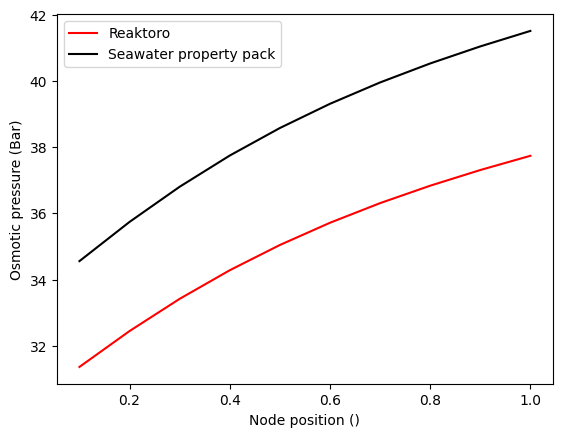

In [321]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

reaktoro_osm = []
sewater_prop_pack_osm = []
for idx in indexes:
    reaktoro_osm.append(
        float(m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"].value/1e5)
    )
    calculate_variable_from_constraint(
        m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"],
        m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase["Liq"],
    )
    sewater_prop_pack_osm.append(
        float(m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"].value/1e5)
    )

ax.plot(indexes, reaktoro_osm, color="red", label="Reaktoro")
ax.plot(indexes, sewater_prop_pack_osm, color="black", label="Seawater property pack")
ax.set(xlabel="Node position ()", ylabel="Osmotic pressure (Bar)")
plt.legend()
plt.show()

Check other properties

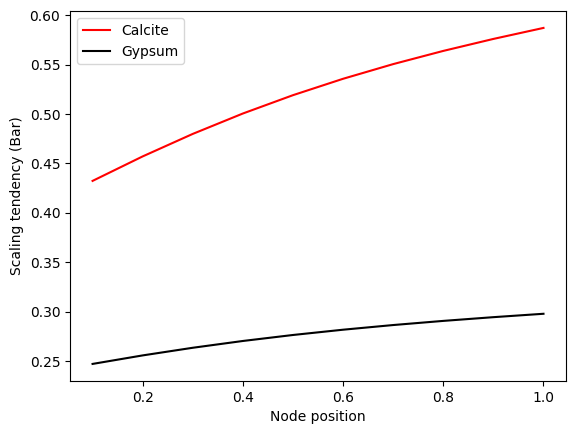

In [322]:
fig, ax = plt.subplots()

scaling_calcite = []
scaling_gypsum = []
for idx in indexes:
    scaling_calcite.append(
        float(m.fs.indexed_outputs[idx, "scalingTendency", "Calcite"].value)
    )
    scaling_gypsum.append(
        float(m.fs.indexed_outputs[idx, "scalingTendency", "Gypsum"].value)
    )
ax.plot(indexes, scaling_calcite, color="red", label="Calcite")
ax.plot(indexes, scaling_gypsum, color="black", label="Gypsum")
ax.set(xlabel="Node position", ylabel="Scaling tendency (Bar)")
plt.legend()
plt.show()

Solve RO for higher recovery. 

Current recovery 0.32918458334579775
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     6644
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      792

Total number of variables............................:     1487
                     variables with only lower bounds:      470
                variables with lower and upper bounds:      378
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1487
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

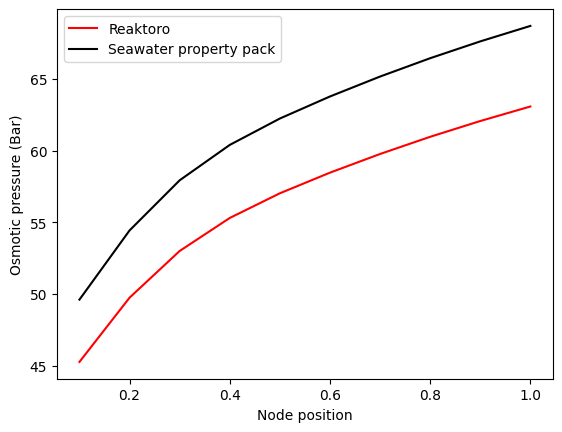

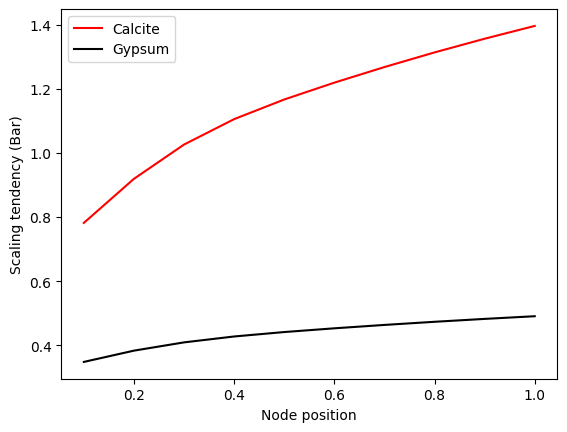

In [323]:
print("Current recovery" , m.fs.RO.recovery_vol_phase[0,'Liq'].value)
m.fs.RO.recovery_vol_phase[0, 'Liq'].fix(0.60)
m.fs.pump.outlet.pressure[0].unfix()
m.fs.RO.area.fix(200) # double our area for higher
result=cy_solver.solve(m,tee=True)
fig, ax = plt.subplots()

reaktoro_osm = []
sewater_prop_pack_osm = []
for idx in indexes:
    reaktoro_osm.append(
        float(m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"].value/1e5)
    )
    calculate_variable_from_constraint(
        m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"],
        m.fs.RO.feed_side.properties_interface[0.0, idx].eq_pressure_osm_phase["Liq"],
    )
    sewater_prop_pack_osm.append(
        float(m.fs.indexed_outputs[idx, "osmoticPressure", "H2O"].value/1e5)
    )

ax.plot(indexes, reaktoro_osm, color="red", label="Reaktoro")
ax.plot(indexes, sewater_prop_pack_osm, color="black", label="Seawater property pack")
ax.set(xlabel="Node position", ylabel="Osmotic pressure (Bar)")
plt.legend()

fig, ax = plt.subplots()

scaling_calcite = []
scaling_gypsum = []
for idx in indexes:
    scaling_calcite.append(
        float(m.fs.indexed_outputs[idx, "scalingTendency", "Calcite"].value)
    )
    scaling_gypsum.append(
        float(m.fs.indexed_outputs[idx, "scalingTendency", "Gypsum"].value)
    )
ax.plot(indexes, scaling_calcite, color="red", label="Calcite")
ax.plot(indexes, scaling_gypsum, color="black", label="Gypsum")
ax.set(xlabel="Node position", ylabel="Scaling tendency (Bar)")
plt.legend()
plt.show()